
# Parallel Computing and Dijikstra's Algorithm  With Julia: A beginner Approach. 



### By Ivan Felipe Rodriguez .


### Dr. Remi Megret. 


### High Performance Computing Class Project. 


###  University of Puerto Rico Mayaguez


# Outline: 

* The parallelism In Julia: 

    * Quick reference and theory. 

    * Examples

* The Dijikstra Algorithm 

    * Serial Implementation
    * Parallel Implementation
    * Speedup and Allocations
    * The Issues.
    * Demo ! :) :)
* Conclusions

    * Problems
    * Opportunities
    
* Future Work 

    * Make it a PACKAGE! follow me at www.github.com/Piperod
    * Fixing parallel 


![](Imagenes/Julia.png)



## Quick Reference Guide:

Starting up. 

   julia -n p
    
   addprocs() : Adds all the posible 

Low-level:

* remotecall(): Call a function asynchronously on the given arguments on the specified process. Returns a Future. Keyword arguments, if any, are passed through to func.

* fetch(): Waits and fetches a value from x depending on the type of x. Does not remove the item fetched:

* @spawn: Creates a closure around an expression and runs it on an automatically-chosen process, returning a RemoteRef to the result.


* @spawnat: Accepts two arguments, p(process) and an expression. A closure is created around the expression and run asynchronously on process p. Returns a Future to the result.



# Examples

In [27]:
ref=remotecall(2,fill,2,2,2)

RemoteRef{Channel{Any}}(2,1,198)

In [28]:
ref=remotecall(2,fill,2,2,2)
fetch(ref)
ref2= @spawnat 1 2 .* fetch(ref)
fetch(ref2)

2x2 Array{Int64,2}:
 2  2
 2  2

In [29]:
ref2= @spawnat 1 2 .* fetch(ref)

RemoteRef{Channel{Any}}(1,1,200)

In [30]:
fetch(ref2)

2x2 Array{Int64,2}:
 4  4
 4  4


High-Level: 


* @parallel (reducer) : Like the openmp `#pragma parallel for`  
  This one is often used in for loops.  HOWEVER IS IMPORTANT TO DEFINE THE REDUCER PROPERLY!
  
* pmaps() : This is a parallel execution for more complicated parallel initializations. 

* SharedArray : This structure is used for shared memory computations
            

* @time : This profile tool measure the time. Shown After the execution. 

* @elapsed : This profile tool measure the time, but does show the output  time rather than the function. 

* @Allocated: This profiling tool measure the allocations in memory. 

# Examples: 

In [37]:
a = zeros(10)
@parallel for i=1:10
  a[i] = i
end
fetch(a)


10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [35]:
a = SharedArray(Int64,10)

@sync @parallel for i=1:10
  a[i] = i
end
fetch(a)

10-element SharedArray{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [1]:
@everywhere function myrange(q::SharedArray)
    idx = indexpids(q)
    if idx == 0
        # This worker is not assigned a piece
        return 1:0, 1:0
    end
    nchunks = length(procs(q))
    splits = [round(Int, s) for s in linspace(0,size(q,2),nchunks+1)]
    1:size(q,1), splits[idx]+1:splits[idx+1]
end

# Here's the kernel
@everywhere function advection_chunk!(q, u, irange, jrange, trange)
    @show (irange, jrange, trange)  # display so we can see what's happening
    for t in trange, j in jrange, i in irange
        q[i,j,t+1] = q[i,j,t] +  u[i,j,t]
    end
    q
end

# Here's a convenience wrapper for a SharedArray implementation
@everywhere advection_shared_chunk!(q, u) = advection_chunk!(q, u, myrange(q)..., 1:size(q,3)-1)

In [3]:
function advection_parallel!(q, u)
    for t = 1:size(q,3)-1
        @sync @parallel for j = 1:size(q,2)
            for i = 1:size(q,1)
                q[i,j,t+1]= q[i,j,t] + u[i,j,t]
            end
        end
    end
    q
end

advection_parallel! (generic function with 1 method)

In [5]:
function advection_shared!(q, u)
    @sync begin
        for p in procs(q)
            @async remotecall_wait(advection_shared_chunk!, p, q, u)
        end
    end
    q
end

advection_shared! (generic function with 1 method)

In [6]:
q = SharedArray(Float64, (500,500,500))
u = SharedArray(Float64, (500,500,500))

# Run once to JIT-compile

advection_parallel!(q, u)
advection_shared!(q,u)


(irange,jrange,trange) = (1:500,1:500,1:499)


500x500x500 SharedArray{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

In [7]:
 @time advection_parallel!(q, u);

  3.518217 seconds (45.76 k allocations: 1.853 MB, 0.46% gc time)


In [8]:
@time advection_shared!(q,u);

(irange,jrange,trange) = (1:500,1:500,1:499)
  3.399157 seconds (460 allocations: 30.719 KB)


## The Algorithm : 

I used the algorithm produced by Madduri et. all. In their paper Parallel Shortest Path Algorihtm for solvin large scale instances. Along with the one by M. Kranjcevic $\Delta$-Stepping Algorithm for Shared Memories Architecture. 

The pseudocode is the following one: 

![](imagenes/algo_1.png)


![](imagenes/algo_2.png)

# Serial Implementation: 

I implemented the following functions. 
* Setup this function basically load the image and prepares the inputs (I will explain this a little bit later) 
* Deltastep. Which performs  the first algorithm. The output are two dictionaries, the first one containing  the tent dictionary which basically keeps the information of how much cost to go from the given node to a different one. And the pred dictionary that will help us getting the path. 
* relax. Which performs the second algorithm
* path :  Taking the second argument from the Deltastep function output it retrieve the minimal path. 


In [51]:

    function Deltastep(list,s,delta)
    C=Dict()
    V=Set()
    tent=Dict()
    B=Dict{Any,Set}()
    E=Set()
    heavy=Dict()
    light=Dict()
    Req=[]
    pred=Dict()
    for item in list 
        C[item[1],item[2]]=item[3]
        push!(V,item[1])
        push!(V,item[2])
        push!(E,[item[1],item[2]])
        heavy[item[1]]=[]
        heavy[item[2]]=[]
        light[item[1]]=[]
        light[item[2]]=[]
        tent[item[1]]=10000000000000
        tent[item[2]]=10000000000000
        pred[item[2]]=10000000000000
    end
 
     #println("C=$C")

    for e in E
        v=e[1]
        w=e[2]
        if C[v,w]>delta
            push!(heavy[v],e)
        else
            push!(light[v],e)
        end
    end
     #println("Heavy: $heavy ")
     #println("Light: $light  ")
     #println("E=$E")
    relax(s,0,delta,B,tent,pred,1000000000)
    i=0
    while isempty(B)==false
         println("B=$B")
         println("tent=$tent")
         #Processing vertices from B[i]
        if haskey(B,i)==true
            S=Set()
             #Relax recursively all light edges while they stay in B[i]
            while isempty(B[i])==false
                 #Push to Req all light edges from vertices in B[i]
                Req=[]
                for v in B[i]
                     println("v=$v")
                    for e in light[v]
                         println("e=$e")
                        push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                    end
                end
                 #Update S
                union!(S,B[i])
                B[i]=Set()
                
                 #Relax all Req edges
                for r in Req
                     println("r=$r")
                    relax(r[1],r[2],delta,B,tent,pred,r[3])
                end
            end
             #Relax all heavy edges of vertices in S
            Req=[]
            delete!(B,i)
            for v in S
                for e in heavy[v]
                    push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                end
            end
            for r in Req
                relax(r[1],r[2],delta,B,tent,pred,r[3])
            end
        end
        
        i=i+1
    end
    
    println("This is the answer: $tent")
  
    return tent,pred
    
   
end 

Deltastep (generic function with 1 method)

In [52]:
function relax(w,d,delta,B,tent,pred,v)
    # println("w : $w")

    if d<tent[w]
        old_i=floor(tent[w]/delta)
        tent[w]=d
        
        if (haskey(B,old_i)==true)
            delete!(B[old_i],w)
            
        else
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), B[old_i=$old_i] not found")
        end
        #Add w to new bin and update its tent
        new_i=floor(d/delta)
        if (haskey(B,new_i)==false)
            B[new_i]=Set()
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), allocated B[fld=$new_i].")
        end
        push!(B[new_i],w)
        tent[w]=d
        if (haskey(pred,w)==false)
            pred[w]=()
            pred[w]=v
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), allocated B[fld=$new_i].")
        else 
            pred[w]=v
        end
        
        # println("The previous node visited was: $pred")
    end
end
        

relax (generic function with 1 method)

In [56]:
function path(pred,w)
  v=w
  path = []
  while v<1000000000
        push!(path,v)
        #println("$path")
        v = pred[v]
   end
    
    return reverse(path)
end

path (generic function with 1 method)

In [11]:
a=Array{Int64}[]
push!(a,[1,2,1])
push!(a,[2,3,1])
push!(a,[3,1,4])
push!(a,[3,4,2])
push!(a,[4,2,5])

5-element Array{Array{Int64,N},1}:
 [1,2,1]
 [2,3,1]
 [3,1,4]
 [3,4,2]
 [4,2,5]

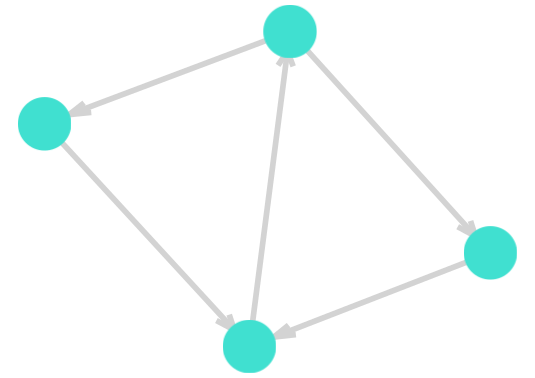

In [12]:
using Graphs
using GraphPlot
graph = simple_graph(4)
for e in a
    add_edge!(graph, e[1], e[2])
end
gplot(graph)

In [54]:
(tent,pred)=Deltastep(a,2,1)


B=Dict{Any,Set{T}}(0.0=>Set(Any[2]))
tent=Dict{Any,Any}(4=>10000000000000,2=>0,3=>10000000000000,1=>10000000000000)
v=2
e=[2,3]
r=[3,1,2]
B=Dict{Any,Set{T}}(1.0=>Set(Any[3]))
tent=Dict{Any,Any}(4=>10000000000000,2=>0,3=>1,1=>10000000000000)
v=3
B=Dict{Any,Set{T}}(3.0=>Set(Any[4]),5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
B=Dict{Any,Set{T}}(3.0=>Set(Any[4]),5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
v=4
B=Dict{Any,Set{T}}(5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
B=Dict{Any,Set{T}}(5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
v=1
e=[1,2]
r=[2,6,1]
This is the answer: Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)


(Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5),Dict{Any,Any}(4=>3,2=>1000000000,3=>2,1=>3))

In [57]:
path(pred,1)

3-element Array{Any,1}:
 2
 3
 1

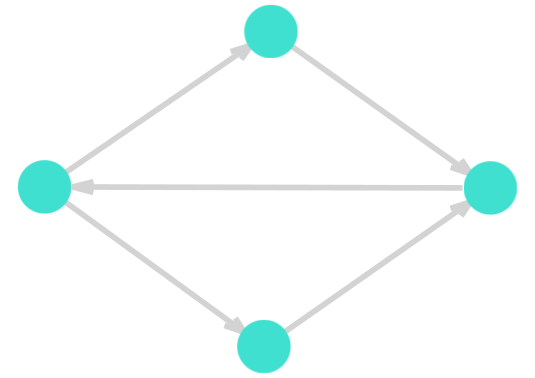

In [13]:
gplot(graph)

# The Inputs

Since we want to process images, I used the following methodology (Code is the setup.jl file). First thing was to cast the information in the proper way. To do so. I define each pixel to be a vertex and each of its possible neighbors are the possible edges coming from that node. The cost is calculate using the gradient of the image. I had first to conver the image into a grayscale. 


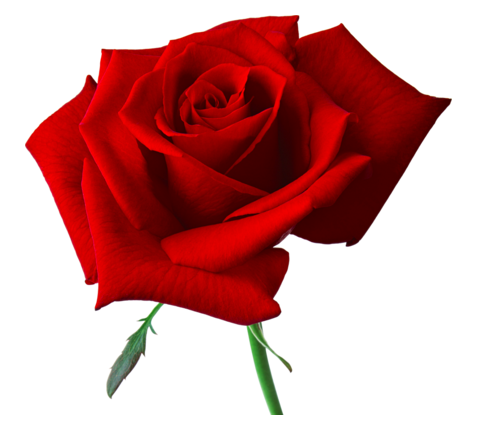

In [2]:
using Images, Colors, FixedPointNumbers, ImageView
Img=load("Imagenes/rose.png") 

In [3]:
Img[28,147]

RGBA{U8}(0.784,0.0,0.055,1.0)

  likely near In[4]:1


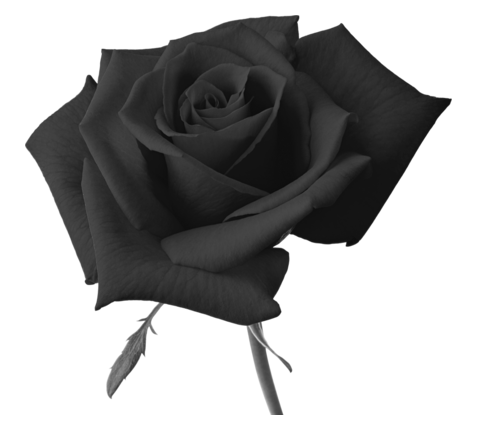

In [4]:
A=convert(Image{Gray{Ufixed8}}, Img)

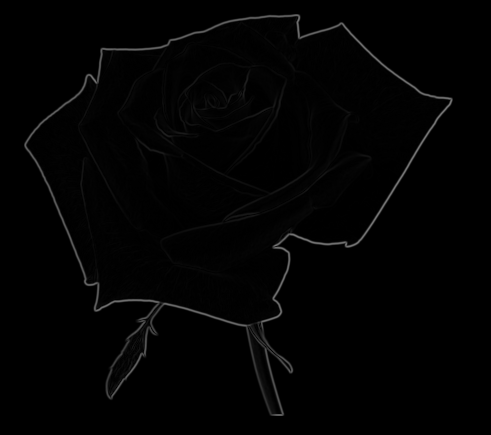

In [5]:
xx,yy=imgradients(A)
c=(sqrt(xx.^2+yy.^2))


In [8]:
cost=1./(c.+1)
view(cost)


(ImageCanvas,ImageSlice2d: zoom = Graphics.BoundingBox(0.0,435.0,0.0,491.0))

![](Imagenes/cost.png)

In [2]:
using Images, Colors, FixedPointNumbers, ImageView
function setup(A)
    
	x,y = size(A)
	list=Array{Float64}[]
	img=convert(Image{Gray{Ufixed8}}, A)
    xx,yy=imgradients(img)
    c=(sqrt(xx.^2+yy.^2))
    cost=1./(c.+1)
    
	for i in x+2:length(A)-(x+1)
       edge=[i,i+1,cost[i+1]]
       push!(list,edge)
       edge=[i,i-1,cost[i-1]]
       push!(list,edge)
       edge=[i,i-x,cost[i-x-1]]
       push!(list,edge)
       edge=[i,i+x,cost[i+x]]
       push!(list,edge)
       edge=[i,i-x-1,cost[i-x-1]]
       push!(list,edge)
       edge=[i,i-x+1,cost[i-x+1]]
       push!(list,edge)
       edge=[i,i+x-1,cost[i+x-1]]
       push!(list,edge)
       edge=[i,i+x+1,cost[i+x+1]]
       push!(list,edge)
	end

return list
end


setup (generic function with 1 method)

# Running and Profiling tools 

In [ ]:
using Images, Colors, FixedPointNumbers, ImageView
img=load("rose.png")
include("setup.jl")
include("deltastep.jl")
include("relax.jl")
include("path.jl")

Delta=@time Deltastep(graph,2,1)
graph=setup(img)

f=open("output.txt","w")
for i in [10,50,100,500,1000]
Time=@elapsed Deltastep(graph,5000,i)
Alloc=@allocated Deltastep(graph,5000,i)
write(f,"  Deltastep : $i Time Elapsed $Time Memory Allocations : $Alloc \n")
end
close(f)

# Parallel. 
 

In [18]:
C=Dict()
@parallel for item in a
    C[item[1],item[2]]=item[3]
end
println("$C")

Dict{Any,Any}()


In [18]:
@everywhere rdc(d::Dict,i::Vector) = begin d[i[1]] = length(graph); d end
@everywhere rdc(d::Vector,i::Vector) = rdc(rdc(Dict(),d),i)
@everywhere rdc(d::Dict,i::Dict) = merge!(d,i)

C = @parallel (rdc) for item in graph
  item
end
println("$C")

Dict{Any,Any}(4=>5,2=>5,3=>5,1=>5)


In [ ]:
@everywhere rde(d::Vector,i::Vector) = rde(rde(Set(),d),i)
@everywhere rde(d::Set,i::Vector) = begin push!(d,[i[1],i[2]]); d end
@everywhere rde(d::Set,i::Set) = union!(d,i)

E= @parallel (rde) for item in graph
        item 
    end
println("$E")

```cpp
using Images, Colors, FixedPointNumbers, ImageView
function setup(A)
	x,y = size(A)
	list=SharedArray{Any,8*x*y-2x}
	img=convert(Image{Gray{Ufixed8}}, A)
    xx,yy=imgradients(img)
    c=(sqrt(xx.^2+yy.^2))
    cost=1./(c.+1)
	@parallel for i in x:length(A)-x
    list[i]=[i,i+1,cost[i+1]]
    list[i+1]=[i,i-1,cost[i-1]]
    list[i+2]=[i,i-y,cost[i-y]]
    list[i+3]=[i,i+y,cost[i+y]]
    list[i+4]=[i,i-y-1,cost[i-y-1]]
    list[i+5]=[i,i-y+1,cost[i-y+1]]
    list[i+6]=[i,i+y-1,cost[i+y-1]]
    list[i+7]=[i,i+y+1,cost[i+y+1]]
	end

return list
end
```

# Code in Parallel 

```cpp 
function Deltastep(list,s,delta)

    @everywhere rdc(d::Vector,i::Vector) = rdc(rdc(Dict(),d),i)
    @everywhere rdc(d::Dict,i::Vector) = begin d[i[1]] = []; d[i[2]] = [];d end
    @everywhere rdc(d::Dict,i::Dict) = merge!(d,i)

    @everywhere rdt(d::Vector,i::Vector) = rdt(rdt(Dict(),d),i)
    @everywhere rdt(d::Dict,i::Vector) = begin d[i[1]] = 1000000000000000;d[i[2]] = 1000000000000000; d end
    @everywhere rdt(d::Dict,i::Dict) = merge!(d,i)
    
    @everywhere rdcc(d::Vector,i::Vector) = rdcc(rdcc(Dict(),d),i)
    @everywhere rdcc(d::Dict,i::Vector) = begin d[i[1],i[2]] = i[3]; d end
    @everywhere rdcc(d::Dict,i::Dict) = merge!(d,i)
    
    @everywhere rds(d::Vector,i::Vector) = rds(rds(Set(),d),i)
    @everywhere rds(d::Set,i::Vector) = begin push!(d,i[1]);push!(d,i[2]); d end
    @everywhere rds(d::Set,i::Set) = union!(d,i)
    
    @everywhere rde(d::Vector,i::Vector) = rde(rde(Set(),d),i)
    @everywhere rde(d::Set,i::Vector) = begin push!(d,[i[1],i[2]]); d end
    @everywhere rde(d::Set,i::Set) = union!(d,i)
   
    
   

```

 ```cpp 
     heavy = @parallel (rdc) for item in list
      item;
    end

    light=@parallel (rdc) for item in list
        item;
    end
    
    tent= @parallel (rdt) for item in list 
        item;
    end
    
    pred= @parallel (rdt) for item in list 
        item;
    end
    
    C = @parallel (rdcc) for item in list 
        item
    end
    
    V = @parallel (rds) for item in list
    item
    end
    E= @parallel (rde) for item in list 
        item 
    end
    
    B=SharedArray{Any,Set}()
   
    Req=[]
    
    # println("Heavy: $heavy ")
    # println("C=$C")

    for e in E
        v=e[1]
        w=e[2]
        if C[v,w]>delta
            push!(heavy[v],e)
        else
            push!(light[v],e)
        end
    end
    
```

```cpp   
    # println("Light: $light  ")
    # println("E=$E")
    relax(s,0,delta,B,tent,pred,1000000000)
    i=0
    while isempty(B)==false
        # println("B=$B")
        # println("tent=$tent")
        # Processing vertices from B[i]
        if haskey(B,i)==true
            S=Set()
            # Relax recursively all light edges while they stay in B[i]
            while isempty(B[i])==false
                # Push to Req all light edges from vertices in B[i]
                Req=[]
                for v in B[i]
                    # println("v=$v")
                    for e in light[v]
                        # println("e=$e")
                        push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                    end
                end
                # Update S
                union!(S,B[i])
                B[i]=Set()
                
                # Relax all Req edges
               @sync @parallel for r in Req
                    # println("r=$r")
                    relax(r[1],r[2],delta,B,tent,pred,r[3])
                end
            end
            # Relax all heavy edges of vertices in S
            Req=[]
            delete!(B,i)
            for v in S
                for e in heavy[v]
                    push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                end
            end
            @sync @parallel for r in Req
                relax(r[1],r[2],delta,B,tent,pred,r[3])
            end
        end
        
        i=i+1
    end
    
    println("This is the answer: $tent")
  
    return tent,pred
end
```

## Results 
![](Imagenes/experiment.png)


![](Imagenes/allocations.png)

# Note

Since julia is still on development (but now is reaching 0.5 dev version) is not available yet on Stampede. I use the binaries available to run it on stampede. But I could not run it with more than 3 process. Everytime I try to run it with more cores I got "Could not allocate pools". 



# Analisis: 

The time speedup using the parallel code was about 2.9 each which is prettymuch linear as expected. However, the problem I described before did not allow me to get more data. The allocations were reduced considerably too, because of the SharedMemory array implementation. 

The parallel implementation  of the algorithm allowed us to think using properly large scale  computers would be posible to escalate the performance of the Delta steepping algorithm. 

# Conclusions: 


Julia parallelism is aiming to Scientific Tec. That make it easy for the syntax and for implementing it. However, because is still growing documentation is not quite developed for learning and training process. Here are important opportunities to learn and to give more resources to others. 

The total work can be summarize: 

    * Original Implemenation of the Delta-stepping algorithm in Julia
    * Implementation of a tool to get the contour of an Image using Julia and Dijikstra. 
    * Documentation for learning the basics of parallelism  in Julia. 
    



## DEMO !!!

![](Imagenes/rose1.png)

# GRACIAS